In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os, json
from datetime import datetime

from xgb import flatten_sequences, build_xgb_model, train_xgb_classifier, XGBTrainConfig
from lstm import train_dual_head_classifier, TrainConfig
from tft import train_tft_classifier, TrainConfig
from data_prep import add_over_under_label, prepare_receiving_sequences
from metrics import compute_ece, compute_pace

from sklearn.metrics import roc_auc_score
from player_utils import predict_player_over_prob

from core_logic import compute_parlay_prob, load_data


### Instructions

Use this Jupyter notebook as the main testing for running models. Changing to model variations comes in several aspects, the list below will lay out how changes effect each aspect.

* Adjust the options below to make different predictions.

Description of acronyms:
| **Receiving** | **Rushing** | **Passing** |
|--------------|-------------|-------------|
| **REC** — Receptions | **CAR** — Carries (Rushing Attempts) | **C_ATT** — Completions / Attempts |
| **YDS** — Receiving Yards | **YDS** — Rushing Yards | **YDS** — Passing Yards |
| **AVG** — Avg Yards/Reception | **AVG** — Avg Yards/Carry | **AVG** — Avg Yards/Attempt |
| **TD** — Receiving TDs | **TD** — Rushing TDs | **TD** — Passing TDs |
| **LONG** — Longest Reception | **LONG** — Longest Rush | **INT** — Interceptions Thrown |
| **TGTS** — Targets |  | **SACKS** — Times Sacked |
|  |  | **QBR** — QB Rating (ESPN) |
|  |  | **RTG** — Passer Rating (NFL) |

| **Defensive** | **Fumbles** | **Interceptions** |
|--------------|-------------|-------------------|
| **TOT** — Total Tackles | **FUM** — Fumbles | **INT** — Interceptions Made |
| **SOLO** — Solo Tackles | **LOST** — Fumbles Lost | **YDS** — INT Return Yards |
| **SACKS** — Sacks | **REC** — Fumble Recoveries | **TD** — Pick-Six Touchdowns |
| **TFL** — Tackles for Loss |  |  |
| **PD** — Passes Defended |  |  |
| **QB_HTS** — QB Hits |  |  |
| **TD** — Defensive TDs |  |  |

| **Kick Returns** | **Punt Returns** | **Kicking** |
|------------------|------------------|-------------|
| **NO** — Number of Returns | **NO** — Number of Returns | **FG** — Field Goals Made |
| **YDS** — Return Yards | **YDS** — Return Yards | **PCT** — FG Percentage |
| **AVG** — Avg Yards/Return | **AVG** — Avg Yards/Return | **LONG** — Longest Field Goal |
| **LONG** — Longest Return | **LONG** — Longest Return | **XP** — Extra Points Made |
| **TD** — Kick Return TDs | **TD** — Punt Return TDs | **PTS** — Total Kicking Points |

| **Punting** |  |  |
|-------------|--|--|
| **NO** — Number of Punts |  |  |
| **YDS** — Total Punting Yards |  |  |
| **AVG** — Avg Yards per Punt |  |  |
| **TB** — Touchbacks |  |  |
| **IN_20** — Inside 20-Yard Line |  |  |
| **LONG** — Longest Punt |  |  |



In [2]:
yard_type = "receiving" 

"""
Options
-------
yard_type = {receiving, passing, rushing, punting, puntreturn, kickreturns, kicking, fumbles, interceptions, defensive}
STAT_COL = # if receiving then you pick 1 option from receiving like "YDS"
    {
        receiving: ["REC", "YDS", "AVG","TD","LONG","TGTS"],
        rushing:   ["CAR","YDS","AVG","TD","LONG"],
        passing:   ["C_ATT",	"YDS","AVG","TD","INT","SACKS","QBR","RTG"],
        defensive: ["TOT","SOLO","SACKS","TFL","PD","QB_HTS","TD"],
        fumbles:   ["FUM", "LOST","REC"],
        interceptions: ["INT","YDS","TD"],
        kickreturns: ["NO","YDS","AVG","LONG","TD"],
        puntreturn: ["NO","YDS","AVG","LONG","TD"],
        kicking: ["FG","PCT","LONG","XP","PTS"],
        punting:  ["NO","YDS","AVG","TB","IN_20","LONG"]
    }
LINE_VALUE = # whatever value is relevant to the yard_type and statistic. Example: kicking - FG could have 2 field goals in a game but 30 is a poor choice.     
N_PAST_GAMES = 3-8
HIDDEN_SIZE = 64-128
D_MODEL = 64-128
"""

train_df = pd.read_csv(f"data/{yard_type}_2019_2023.csv")
test_df  = pd.read_csv(f"data/{yard_type}_24tocurrent.csv")

LINE_VALUE = 80 # the threshold of going over.      
N_PAST_GAMES = 5 # the number of previous games
HIDDEN_SIZE = 128 # number of hidden layers
STAT_COL  = "YDS" # chosen columnd to predict on
D_MODEL = 128 # dimension of the tft model


train_df = add_over_under_label(train_df, stat_col=STAT_COL, line_value=LINE_VALUE, new_col="over_label")
test_df  = add_over_under_label(test_df,  stat_col=STAT_COL, line_value=LINE_VALUE, new_col="over_label")

# LSTM TEST

In [3]:
X_train, y_train, lengths_train, meta_train = prepare_receiving_sequences(
    train_df,
    n_past_games=N_PAST_GAMES,
    target_col="over_label",
)

X_test, y_test, lengths_test, meta_test = prepare_receiving_sequences(
    test_df,
    n_past_games=N_PAST_GAMES,
    target_col="over_label",
)

cfg = TrainConfig(
    n_epochs=10,
    batch_size=64,
    lr=1e-3,
    device="auto",
    verbose=True,
)

train_result = train_dual_head_classifier(
    X=X_train,
    y=y_train,
    lengths=lengths_train,
    hidden_size=HIDDEN_SIZE,
    cfg=cfg,
)

model = train_result["model"]
history = train_result["history"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
len_train_t = torch.tensor(lengths_train, dtype=torch.long).to(device)

with torch.no_grad():
    y_reg_train, logits_train = model(X_train_t, len_train_t)
    probs_train = torch.sigmoid(logits_train).cpu().numpy()

y_true_train = np.asarray(y_train)

auc_train   = roc_auc_score(y_true_train, probs_train)
ece_train   = compute_ece(y_true_train, probs_train)
pace2_train = compute_pace(y_true_train, probs_train, L=2)

print("\n=== Train Metrics (Single-Leg + Parlay) ===")
print(f"AUC_train   : {auc_train:.4f}")
print(f"ECE_train   : {ece_train:.4f}")
print(f"PaCE2_train : {pace2_train:.4f}  (random 2-leg parlays)")

X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
len_test_t = torch.tensor(lengths_test, dtype=torch.long).to(device)

with torch.no_grad():
    y_reg_test, logits_test = model(X_test_t, len_test_t)
    probs_test = torch.sigmoid(logits_test).cpu().numpy()

y_true_test = np.asarray(y_test)

auc_test   = roc_auc_score(y_true_test, probs_test)
ece_test   = compute_ece(y_true_test, probs_test)
pace2_test = compute_pace(y_true_test, probs_test, L=2)

print("\n=== Test Metrics (Single-Leg + Parlay) ===")
print(f"AUC_test   : {auc_test:.4f}")
print(f"ECE_test   : {ece_test:.4f}")
print(f"PaCE2_test : {pace2_test:.4f}  (random 2-leg parlays)")


os.makedirs("models", exist_ok=True)
os.makedirs("metrics", exist_ok=True)

model_tag = f"lstm_dual_receiving_{STAT_COL.lower()}_line_{LINE_VALUE:.1f}_past{N_PAST_GAMES}_hid{HIDDEN_SIZE}"

model_path   = os.path.join("models",  model_tag + ".pt")
metrics_path_lstm = os.path.join("metrics", model_tag + "_metrics.json")

model_cpu = model.to("cpu")
torch.save(model_cpu.state_dict(), model_path)
print(f"Saved model to {model_path}")

metrics_payload = {
    "timestamp": datetime.now().isoformat(),
    "STAT_COL": STAT_COL,
    "line_value": LINE_VALUE,
    "n_past_games": N_PAST_GAMES,
    "hidden_size": HIDDEN_SIZE,
    "train_cfg": {
        "n_epochs": cfg.n_epochs,
        "batch_size": cfg.batch_size,
        "lr": cfg.lr,
        "device": cfg.device,
    },
    "train_history": history,  # per-epoch losses
    "train_metrics": {
        "auc": float(auc_train),
        "ece": float(ece_train),
        "pace2": float(pace2_train),
        "n_train": int(len(y_true_train)),
    },
    "test_metrics": {
        "auc": float(auc_test),
        "ece": float(ece_test),
        "pace2": float(pace2_test),
        "n_test": int(len(y_true_test)),
    },
}

with open(metrics_path_lstm, "w") as f:
    json.dump(metrics_payload, f, indent=2)

print(f"Saved metrics to {metrics_path_lstm}")

Epoch 01 | Train BCE loss: 0.2586
Epoch 02 | Train BCE loss: 0.2436
Epoch 03 | Train BCE loss: 0.2423
Epoch 04 | Train BCE loss: 0.2422
Epoch 05 | Train BCE loss: 0.2407
Epoch 06 | Train BCE loss: 0.2402
Epoch 07 | Train BCE loss: 0.2394
Epoch 08 | Train BCE loss: 0.2398
Epoch 09 | Train BCE loss: 0.2399
Epoch 10 | Train BCE loss: 0.2391

=== Train Metrics (Single-Leg + Parlay) ===
AUC_train   : 0.8416
ECE_train   : 0.0097
PaCE2_train : 0.0140  (random 2-leg parlays)

=== Test Metrics (Single-Leg + Parlay) ===
AUC_test   : 0.8164
ECE_test   : 0.0114
PaCE2_test : 0.0126  (random 2-leg parlays)
Saved model to models/lstm_dual_receiving_yds_line_80.0_past5_hid128.pt
Saved metrics to metrics/lstm_dual_receiving_yds_line_80.0_past5_hid128_metrics.json


Plot saved to: plots/LSTM_Metrics_YDS_Line80_Past5.png


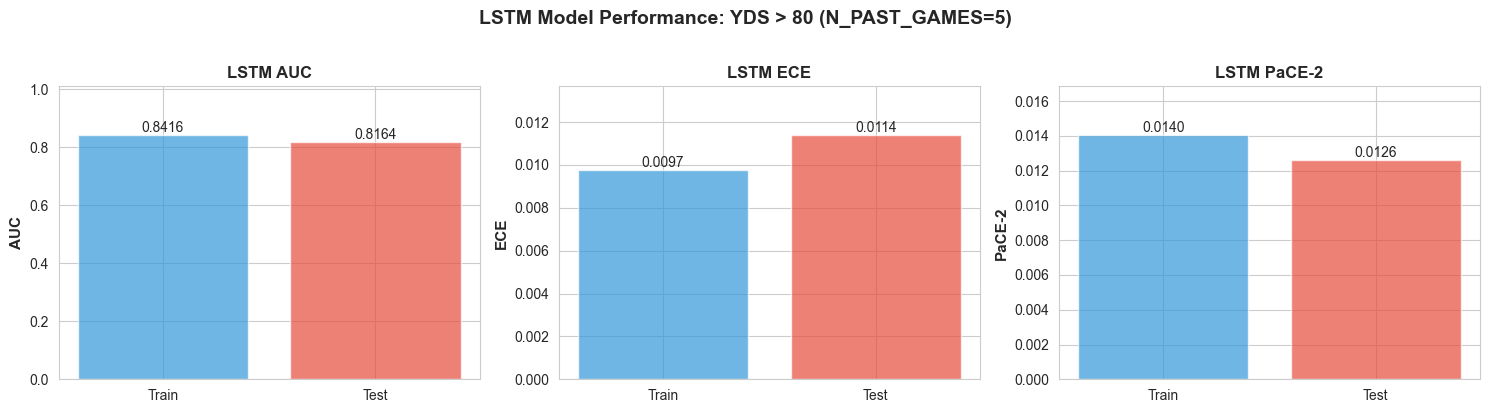

In [4]:
# LSTM Performance Visualization
%matplotlib inline

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Metric comparison: Train vs Test
metrics_names = ['AUC', 'ECE', 'PaCE-2']
train_metrics = [auc_train, ece_train, pace2_train]
test_metrics = [auc_test, ece_test, pace2_test]

x = np.arange(len(metrics_names))
width = 0.35

for i, (metric_name, train_val, test_val) in enumerate(zip(metrics_names, train_metrics, test_metrics)):
    ax = axes[i]
    bars = ax.bar(['Train', 'Test'], [train_val, test_val], color=['#3498db', '#e74c3c'], alpha=0.7)
    ax.set_ylabel(metric_name, fontsize=11, fontweight='bold')
    ax.set_title(f'LSTM {metric_name}', fontsize=12, fontweight='bold')
    ax.set_ylim(0, max(train_val, test_val) * 1.2)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10)

plt.suptitle(f'LSTM Model Performance: {STAT_COL} > {LINE_VALUE} (N_PAST_GAMES={N_PAST_GAMES})', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()

# Save plot
os.makedirs("plots", exist_ok=True)
plot_filename = f"LSTM_Metrics_{STAT_COL}_Line{LINE_VALUE}_Past{N_PAST_GAMES}.png"
plt.savefig(os.path.join("plots", plot_filename), dpi=300, bbox_inches='tight')
print(f"Plot saved to: plots/{plot_filename}")

plt.show()

## LSTM TEST for single leg probabilities

In [5]:
player_name = "George Kittle"

prob = predict_player_over_prob(
    model=model,
    df=test_df,              
    player_name=player_name,
    stat_col=STAT_COL,
    line_value=LINE_VALUE,
    n_past_games=N_PAST_GAMES,
)

print(f"Player: {player_name}")
print(f"Prop: {STAT_COL} over {LINE_VALUE}")
print(f"Predicted probability (model): {prob:.3f}")

Player: George Kittle
Prop: YDS over 80
Predicted probability (model): 0.020


## LSTM TEST for multi leg probabilities
##### The settings below are set for each model afterwards. So to more easily compare, change them here then run each model LSTM, TFT and XGBoost

Options 
For yard_type include:
    "Receiving"
    "Rushing"
    "Passing"
    "Defensive"
    "Fumbles"
    "Interceptions"
    "Kicking"
    "Kick Returns"
    "Punting"
    "Punt Returns"

For parlay_legs:
**Each of the legs can fall under the pretrained and tested model, this means that we must use receiving and can use yards if we trained on receiving and YDS.**
    
    You cannot switch yard_types in multi-leg (like passing and receiving) but you can mix and match within receiving.
    If there is no already trained model for that specific leg, one will be trained and tested.


In [6]:
yard_type = "Receiving" 

train_df, test_df, full_df = load_data(yard_type)

In [7]:
parlay_legs = [
    {
        "player": "George Kittle",
        "stat_col": "YDS",
        "line_value": 55.5,
    },
    {
        "player": "Brandon Aiyuk",
        "stat_col": "TGTS",
        "line_value": 2,
    },
]

In [8]:
parlay_model_choice = "LSTM"  # or "TFT" or "XGBoost"

parlay_prob, leg_probs = compute_parlay_prob(
    parlay_legs=parlay_legs,
    yard_type=yard_type,
    parlay_model_choice=parlay_model_choice,
    train_df=train_df,
    test_df=test_df,
    full_df=full_df,
)

print(f"\nParlay model family: {parlay_model_choice}")
for leg, p in leg_probs:
    print(
        f"Leg: {leg['player']} – {leg['stat_col']} > {leg['line_value']} "
        f"→ P(hit) = {p:.3f}"
    )

print(f"\nP(all legs hit) = {parlay_prob:.3f}")


Parlay model family: LSTM
Leg: George Kittle – YDS > 55.5 → P(hit) = 0.156
Leg: Brandon Aiyuk – TGTS > 2 → P(hit) = 0.922

P(all legs hit) = 0.143


# TFT TEST

Options for the TFT configuration are in TrainConfig and for training those options are in train_tft_classifier.



In [9]:
train_df_labeled = add_over_under_label(
    df=train_df,
    stat_col=STAT_COL,
    line_value=LINE_VALUE,
    new_col="over_label",
)

test_df_labeled = add_over_under_label(
    df=test_df,
    stat_col=STAT_COL,
    line_value=LINE_VALUE,
    new_col="over_label",
)

# 2) Build sequences using that label
X_train, y_train, lengths_train, meta_train = prepare_receiving_sequences(
    train_df_labeled,
    n_past_games=N_PAST_GAMES,
    target_col="over_label",
)

X_test, y_test, lengths_test, meta_test = prepare_receiving_sequences(
    test_df_labeled,
    n_past_games=N_PAST_GAMES,
    target_col="over_label",
)

# 3) Train TFT classifier
cfg = TrainConfig(
    n_epochs=10,
    batch_size=64,
    lr=1e-3,
    device="auto",
    verbose=True,
)

train_result = train_tft_classifier(
    X=X_train,
    y=y_train,
    lengths=lengths_train,
    d_model=D_MODEL,
    n_heads=4,
    num_layers=2,
    dropout=0.1,
    cfg=cfg,
)

model   = train_result["model"]
history = train_result["history"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# 4) Train metrics
X_train_t  = torch.tensor(X_train, dtype=torch.float32).to(device)
len_train_t = torch.tensor(lengths_train, dtype=torch.long).to(device)

with torch.no_grad():
    y_reg_train, logits_train = model(X_train_t, len_train_t)
    probs_train = torch.sigmoid(logits_train).cpu().numpy()

y_true_train = np.asarray(y_train)

auc_train   = roc_auc_score(y_true_train, probs_train)
ece_train   = compute_ece(y_true_train, probs_train)
pace2_train = compute_pace(y_true_train, probs_train, L=2)

print("\n=== TFT Train Metrics (Single-Leg + Parlay) ===")
print(f"AUC_train   : {auc_train:.4f}")
print(f"ECE_train   : {ece_train:.4f}")
print(f"PaCE2_train : {pace2_train:.4f}  (random 2-leg parlays)")

# 5) Test metrics
X_test_t   = torch.tensor(X_test, dtype=torch.float32).to(device)
len_test_t = torch.tensor(lengths_test, dtype=torch.long).to(device)

with torch.no_grad():
    y_reg_test, logits_test = model(X_test_t, len_test_t)
    probs_test = torch.sigmoid(logits_test).cpu().numpy()

y_true_test = np.asarray(y_test)

auc_test   = roc_auc_score(y_true_test, probs_test)
ece_test   = compute_ece(y_true_test, probs_test)
pace2_test = compute_pace(y_true_test, probs_test, L=2)

print("\n=== TFT Test Metrics (Single-Leg + Parlay) ===")
print(f"AUC_test   : {auc_test:.4f}")
print(f"ECE_test   : {ece_test:.4f}")
print(f"PaCE2_test : {pace2_test:.4f}  (random 2-leg parlays)")

# 6) Save model + metrics
os.makedirs("models", exist_ok=True)
os.makedirs("metrics", exist_ok=True)

model_tag   = f"tft_dual_receiving_{STAT_COL.lower()}_line_{LINE_VALUE:.1f}_past{N_PAST_GAMES}_dmodel{D_MODEL}"
model_path  = os.path.join("models",  model_tag + ".pt")
metrics_path_tft = os.path.join("metrics", model_tag + "_metrics.json")

model_cpu = model.to("cpu")
torch.save(model_cpu.state_dict(), model_path)
print(f"Saved TFT model to {model_path}")

metrics_payload = {
    "timestamp": datetime.now().isoformat(),
    "stat_col": STAT_COL,
    "line_value": LINE_VALUE,
    "n_past_games": N_PAST_GAMES,
    "d_model": D_MODEL,
    "train_cfg": {
        "n_epochs": cfg.n_epochs,
        "batch_size": cfg.batch_size,
        "lr": cfg.lr,
        "device": cfg.device,
    },
    "train_history": history,
    "train_metrics": {
        "auc": float(auc_train),
        "ece": float(ece_train),
        "pace2": float(pace2_train),
        "n_train": int(len(y_true_train)),
    },
    "test_metrics": {
        "auc": float(auc_test),
        "ece": float(ece_test),
        "pace2": float(pace2_test),
        "n_test": int(len(y_true_test)),
    },
}

with open(metrics_path_tft, "w") as f:
    json.dump(metrics_payload, f, indent=2)

print(f"Saved TFT metrics to {metrics_path_tft}")

/home/epx8hh/.local/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[TFT] Epoch 01 | Train BCE loss: 0.2674
[TFT] Epoch 02 | Train BCE loss: 0.2527
[TFT] Epoch 03 | Train BCE loss: 0.2504
[TFT] Epoch 04 | Train BCE loss: 0.2504
[TFT] Epoch 05 | Train BCE loss: 0.2490
[TFT] Epoch 06 | Train BCE loss: 0.2496
[TFT] Epoch 07 | Train BCE loss: 0.2471
[TFT] Epoch 08 | Train BCE loss: 0.2474
[TFT] Epoch 09 | Train BCE loss: 0.2468
[TFT] Epoch 10 | Train BCE loss: 0.2464

=== TFT Train Metrics (Single-Leg + Parlay) ===
AUC_train   : 0.8323
ECE_train   : 0.0232
PaCE2_train : 0.0126  (random 2-leg parlays)

=== TFT Test Metrics (Single-Leg + Parlay) ===
AUC_test   : 0.8084
ECE_test   : 0.0170
PaCE2_test : 0.0147  (random 2-leg parlays)
Saved TFT model to models/tft_dual_receiving_yds_line_80.0_past5_dmodel128.pt
Saved TFT metrics to metrics/tft_dual_receiving_yds_line_80.0_past5_dmodel128_metrics.json


Plot saved to: plots/TFT_Metrics_YDS_Line80_Past5_DModel128.png


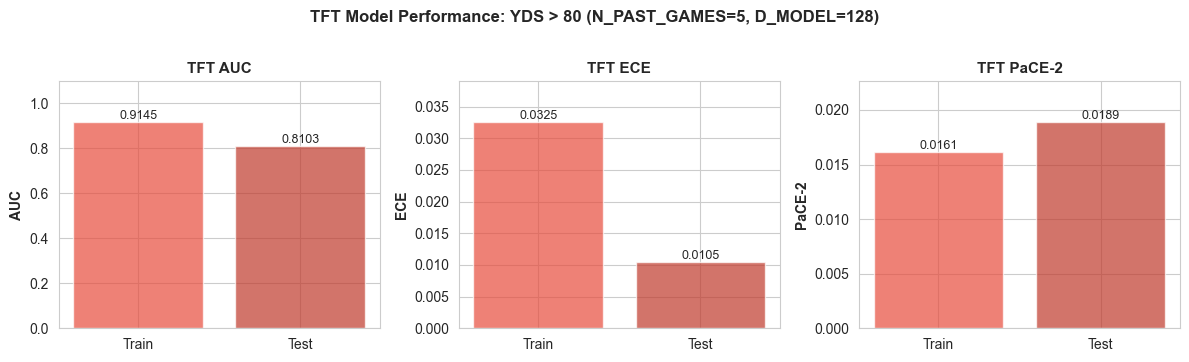

In [17]:
# Enable inline plotting for Jupyter
%matplotlib inline

# TFT Performance Visualization
fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))  # Reduced size

# Metric comparison: Train vs Test
metrics_names = ['AUC', 'ECE', 'PaCE-2']
train_metrics = [auc_train, ece_train, pace2_train]
test_metrics = [auc_test, ece_test, pace2_test]

for i, (metric_name, train_val, test_val) in enumerate(zip(metrics_names, train_metrics, test_metrics)):
    ax = axes[i]
    bars = ax.bar(['Train', 'Test'], [train_val, test_val], color=['#e74c3c', '#c0392b'], alpha=0.7)
    ax.set_ylabel(metric_name, fontsize=10, fontweight='bold')
    ax.set_title(f'TFT {metric_name}', fontsize=11, fontweight='bold')
    ax.set_ylim(0, max(train_val, test_val) * 1.2)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=9)

plt.suptitle(f'TFT Model Performance: {STAT_COL} > {LINE_VALUE} (N_PAST_GAMES={N_PAST_GAMES}, D_MODEL={D_MODEL})', 
             fontsize=12, fontweight='bold', y=1.02)
plt.tight_layout()

# Save plot
plot_filename = f"TFT_Metrics_{STAT_COL}_Line{LINE_VALUE}_Past{N_PAST_GAMES}_DModel{D_MODEL}.png"
plt.savefig(os.path.join("plots", plot_filename), dpi=150, bbox_inches='tight')
print(f"Plot saved to: plots/{plot_filename}")

plt.show()
plt.close()

## TFT TEST for single leg probabilities

In [18]:
player_name = "George Kittle"

prob = predict_player_over_prob(
    model=model,
    df=test_df,
    player_name=player_name,
    stat_col=STAT_COL,
    line_value=LINE_VALUE,
    n_past_games=N_PAST_GAMES,
    model_type="tft"
)

print(f"\n[TFT] Player: {player_name}")
print(f"Prop: {STAT_COL} over {LINE_VALUE}")
print(f"Predicted probability (model): {prob:.3f}")


[TFT] Player: George Kittle
Prop: YDS over 80
Predicted probability (model): 0.068


## TFT TEST for multi leg probabilities

Options for this cell below were set above in LSTM

In [19]:
parlay_model_choice = "TFT" 

parlay_prob, leg_probs = compute_parlay_prob(
    parlay_legs=parlay_legs,
    yard_type=yard_type,
    parlay_model_choice=parlay_model_choice,
    train_df=train_df,
    test_df=test_df,
    full_df=full_df,
)

print(f"\nParlay model family: {parlay_model_choice}")
for leg, p in leg_probs:
    print(
        f"Leg: {leg['player']} – {leg['stat_col']} > {leg['line_value']} "
        f"→ P(hit) = {p:.3f}"
    )

print(f"\nP(all legs hit) = {parlay_prob:.3f}")

/home/epx8hh/.local/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



Parlay model family: TFT
Leg: George Kittle – YDS > 55.5 → P(hit) = 0.149
Leg: Brandon Aiyuk – TGTS > 2 → P(hit) = 0.933

P(all legs hit) = 0.139


/home/epx8hh/.local/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


# XGBoost TEST

Options for the XGBoost configuration are in XGBTrainConfig and for training those options are in train_xgb_classifier.

In [20]:
train_df_labeled = add_over_under_label(
    df=train_df,
    stat_col=STAT_COL,
    line_value=LINE_VALUE,
    new_col="over_label",
)

test_df_labeled = add_over_under_label(
    df=test_df,
    stat_col=STAT_COL,
    line_value=LINE_VALUE,
    new_col="over_label",
)

X_train, y_train, lengths_train, meta_train = prepare_receiving_sequences(
    train_df_labeled,
    n_past_games=N_PAST_GAMES,
    target_col="over_label",
)

X_test, y_test, lengths_test, meta_test = prepare_receiving_sequences(
    test_df_labeled,
    n_past_games=N_PAST_GAMES,
    target_col="over_label",
)


xgb_cfg = XGBTrainConfig(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="logloss",
    verbose=False,
)

xgb_result = train_xgb_classifier(
    X=X_train,
    y=y_train,
    lengths=lengths_train,
    cfg=xgb_cfg,
)

xgb_model = xgb_result["model"]
xgb_history = xgb_result["history"]


X_train_flat = flatten_sequences(X_train)

y_train_np = np.asarray(y_train, dtype=float)
train_probs = xgb_model.predict_proba(X_train_flat)[:, 1]

auc_train   = roc_auc_score(y_train_np, train_probs)
ece_train   = compute_ece(y_train_np, train_probs)
pace2_train = compute_pace(y_train_np, train_probs, L=2)

print("\n=== XGB Train Metrics (Single-Leg + Parlay) ===")
print(f"AUC_train   : {auc_train:.4f}")
print(f"ECE_train   : {ece_train:.4f}")
print(f"PaCE2_train : {pace2_train:.4f}  (random 2-leg parlays)")


# =======================================================
# 5. TEST METRICS
# =======================================================
X_test_flat = flatten_sequences(X_test)

y_test_np = np.asarray(y_test, dtype=float)
test_probs = xgb_model.predict_proba(X_test_flat)[:, 1]

auc_test   = roc_auc_score(y_test_np, test_probs)
ece_test   = compute_ece(y_test_np, test_probs)
pace2_test = compute_pace(y_test_np, test_probs, L=2)

print("\n=== XGB Test Metrics (Single-Leg + Parlay) ===")
print(f"AUC_test   : {auc_test:.4f}")
print(f"ECE_test   : {ece_test:.4f}")
print(f"PaCE2_test : {pace2_test:.4f}  (random 2-leg parlays)")


# =======================================================
# 6. SAVE MODEL + METRICS
# =======================================================
os.makedirs("models", exist_ok=True)
os.makedirs("metrics", exist_ok=True)

model_tag = f"xgb_dual_receiving_{STAT_COL.lower()}_line_{LINE_VALUE:.1f}_past{N_PAST_GAMES}"

model_path   = os.path.join("models",  model_tag + ".json")
metrics_path_xgb = os.path.join("metrics", model_tag + "_metrics.json")

xgb_model.save_model(model_path)
print(f"Saved XGB model to {model_path}")

metrics_payload = {
    "timestamp": datetime.now().isoformat(),
    "stat_col": STAT_COL,
    "line_value": LINE_VALUE,
    "n_past_games": N_PAST_GAMES,

    "xgb_cfg": {
        "n_estimators": xgb_cfg.n_estimators,
        "max_depth": xgb_cfg.max_depth,
        "learning_rate": xgb_cfg.learning_rate,
        "subsample": xgb_cfg.subsample,
        "colsample_bytree": xgb_cfg.colsample_bytree,
        "reg_lambda": xgb_cfg.reg_lambda,
        "reg_alpha": xgb_cfg.reg_alpha,
        "eval_metric": xgb_cfg.eval_metric,
    },

    "train_history": xgb_history,

    "train_metrics": {
        "auc": float(auc_train),
        "ece": float(ece_train),
        "pace2": float(pace2_train),
        "n_train": int(len(y_train_np)),
    },

    "test_metrics": {
        "auc": float(auc_test),
        "ece": float(ece_test),
        "pace2": float(pace2_test),
        "n_test": int(len(y_test_np)),
    },
}

with open(metrics_path_xgb, "w") as f:
    json.dump(metrics_payload, f, indent=2)

print(f"Saved XGB metrics to {metrics_path_xgb}")

/home/epx8hh/.conda/envs/dsvenv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [20:34:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGB Train Metrics (Single-Leg + Parlay) ===
AUC_train   : 0.9145
ECE_train   : 0.0325
PaCE2_train : 0.0154  (random 2-leg parlays)

=== XGB Test Metrics (Single-Leg + Parlay) ===
AUC_test   : 0.8103
ECE_test   : 0.0105
PaCE2_test : 0.0149  (random 2-leg parlays)
Saved XGB model to models/xgb_dual_receiving_yds_line_80.0_past5.json
Saved XGB metrics to metrics/xgb_dual_receiving_yds_line_80.0_past5_metrics.json


Plot saved to: plots/XGBoost_Metrics_YDS_Line80_Past5.png


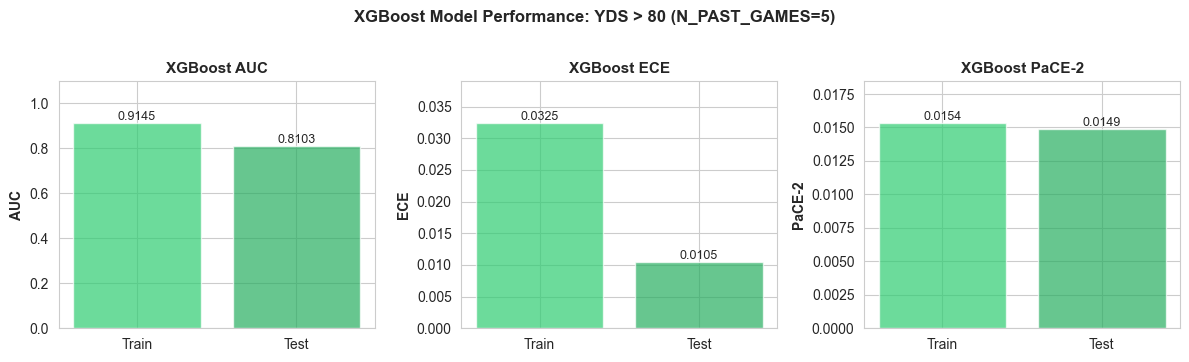

In [21]:
# Enable inline plotting for Jupyter
%matplotlib inline

# XGBoost Performance Visualization
fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))  # Reduced size

# Metric comparison: Train vs Test
metrics_names = ['AUC', 'ECE', 'PaCE-2']
train_metrics = [auc_train, ece_train, pace2_train]
test_metrics = [auc_test, ece_test, pace2_test]

for i, (metric_name, train_val, test_val) in enumerate(zip(metrics_names, train_metrics, test_metrics)):
    ax = axes[i]
    bars = ax.bar(['Train', 'Test'], [train_val, test_val], color=['#2ecc71', '#27ae60'], alpha=0.7)
    ax.set_ylabel(metric_name, fontsize=10, fontweight='bold')
    ax.set_title(f'XGBoost {metric_name}', fontsize=11, fontweight='bold')
    ax.set_ylim(0, max(train_val, test_val) * 1.2)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=9)

plt.suptitle(f'XGBoost Model Performance: {STAT_COL} > {LINE_VALUE} (N_PAST_GAMES={N_PAST_GAMES})', 
             fontsize=12, fontweight='bold', y=1.02)
plt.tight_layout()

# Save plot
plot_filename = f"XGBoost_Metrics_{STAT_COL}_Line{LINE_VALUE}_Past{N_PAST_GAMES}.png"
plt.savefig(os.path.join("plots", plot_filename), dpi=150, bbox_inches='tight')
print(f"Plot saved to: plots/{plot_filename}")

plt.show()
plt.close()

In [22]:
player_name = "Amon-Ra St. Brown"

prob_xgb = predict_player_over_prob(
    model=xgb_model,
    df=test_df,
    player_name=player_name,
    stat_col=STAT_COL,       
    line_value=LINE_VALUE,    
    n_past_games=N_PAST_GAMES,
    model_type="xgboost",   
)

print(f"[XGBoost] Player: {player_name}")
print(f"Prop: {STAT_COL} over {LINE_VALUE}")
print(f"Predicted probability (model): {prob_xgb:.3f}")

[XGBoost] Player: Amon-Ra St. Brown
Prop: YDS over 80
Predicted probability (model): 0.410


## XGB TEST for multi leg probabilities

These options were set above in LSTM. (yard_type, parlay_legs)

In [23]:
parlay_model_choice = "XGBoost" 

parlay_prob, leg_probs = compute_parlay_prob(
    parlay_legs=parlay_legs,
    yard_type=yard_type,
    parlay_model_choice=parlay_model_choice,
    train_df=train_df,
    test_df=test_df,
    full_df=full_df,
)

print(f"\nParlay model family: {parlay_model_choice}")
for leg, p in leg_probs:
    print(
        f"Leg: {leg['player']} – {leg['stat_col']} > {leg['line_value']} "
        f"→ P(hit) = {p:.3f}"
    )

print(f"\nP(all legs hit) = {parlay_prob:.3f}")

/home/epx8hh/.conda/envs/dsvenv/lib/python3.12/pickle.py:1760: UserWarning: [20:34:48] WARNING: /workspace/src/collective/../data/../common/error_msg.h:83: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)



Parlay model family: XGBoost
Leg: George Kittle – YDS > 55.5 → P(hit) = 0.090
Leg: Brandon Aiyuk – TGTS > 2 → P(hit) = 0.910

P(all legs hit) = 0.082


## Comparison

Plot saved to: plots/ModelComparison_YDS_Line80_Past5.png


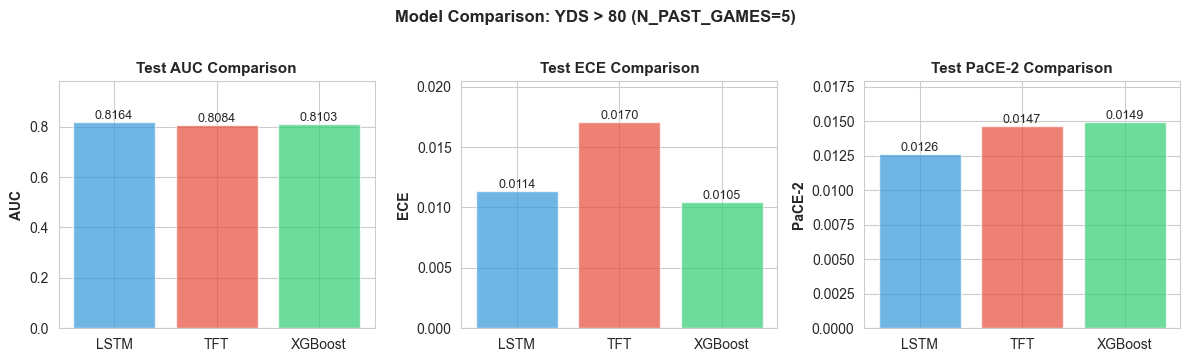

In [24]:
%matplotlib inline

# Model Comparison: LSTM vs TFT vs XGBoost
fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))  # Reduced size

models = ['LSTM', 'TFT', 'XGBoost']
colors = ['#3498db', '#e74c3c', '#2ecc71']


lstm_metrics = pd.read_json(metrics_path_lstm, orient="index")
test_lstm = lstm_metrics[0]['test_metrics']
tft_metrics = pd.read_json(metrics_path_tft, orient="index")
test_tft = tft_metrics[0]['test_metrics']
xgb_metrics = pd.read_json(metrics_path_xgb, orient="index")
test_xgb = xgb_metrics[0]['test_metrics']


metrics_data = {
    'AUC': [test_lstm['auc'], test_tft['auc'], test_xgb['auc']],  # Replace with your actual variable names
    'ECE': [test_lstm['ece'], test_tft['ece'], test_xgb['ece']],
    'PaCE-2': [test_lstm['pace2'], test_tft['pace2'], test_xgb['pace2']]
}

for i, (metric_name, values) in enumerate(metrics_data.items()):
    ax = axes[i]
    bars = ax.bar(models, values, color=colors, alpha=0.7)
    ax.set_ylabel(metric_name, fontsize=10, fontweight='bold')
    ax.set_title(f'Test {metric_name} Comparison', fontsize=11, fontweight='bold')
    ax.set_ylim(0, max(values) * 1.2)
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.4f}',
                ha='center', va='bottom', fontsize=9)

plt.suptitle(f'Model Comparison: {STAT_COL} > {LINE_VALUE} (N_PAST_GAMES={N_PAST_GAMES})', 
             fontsize=12, fontweight='bold', y=1.02)
plt.tight_layout()

# Save plot
plot_filename = f"ModelComparison_{STAT_COL}_Line{LINE_VALUE}_Past{N_PAST_GAMES}.png"
plt.savefig(os.path.join("plots", plot_filename), dpi=150, bbox_inches='tight')
print(f"Plot saved to: plots/{plot_filename}")

plt.show()
plt.close()